In [80]:
import pandas as pd
pd.Series
import math
import csv
from datetime import datetime
from datetime import date
import numpy as np
import scipy as sc
import statsmodels
import sklearn
from sklearn import preprocessing
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 10
rcParams.update({'font.size': 22})
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from matplotlib import pyplot
import statsmodels.api as sm

import holidays

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Load file, print info and select columns

In [81]:
#function to load files
def load_file(filepath):
    df = pd.read_csv(filepath, sep='\t', index_col=0, parse_dates=True)
    df = df.sort_index()
    #we can check that this 2 columns are equal, so we can drop one
    #any(df['SALE_AMOUNT_BEFORE_CANCELLATIONS'] != df['SALE_AMOUNT_AFTER_CANCELLATIONS'])
    df = df.drop(['SALE_AMOUNT_AFTER_CANCELLATIONS', 'WEEKDAY'], axis=1)
    df = df.rename(columns={'SALE_AMOUNT_BEFORE_CANCELLATIONS': 'SALE_AMOUNT'})
#...
    return df.astype('float32')

def add_timeindex_features(df):
    data_df = df.copy()
    data_df['month'] = data_df.index.month
    data_df['year'] = data_df.index.year
    data_df['quater'] = data_df.index.quarter
    data_df['week_day'] = data_df.index.dayofweek
    data_df['week_of_year'] = data_df.index.weekofyear
    data_df['day_of_year'] = data_df.index.dayofyear
    return data_df

#function to create a new df with selected columns
def create_small_df(df, columns):
    small_df = df.copy()
    small_df = small_df[columns]
    return small_df

#function to print inf about Data
def print_info_df(df, print_columns = False):
    #Count period
    d1 = df.index[0]
    d2 = df.index[-1]
    delta = d2 - d1
    print('Number of days is ' + str(delta.days) + ' from ' + str(d1) + ' to '+ str(d2))
    print('The shape of the data: %d*%d' %(df.shape[0],df.shape[1]))
    print('Check for Nan values: %s'%(df.isnull().values.any()))
    if (print_columns == True):
        print(list(df.columns))
    else:
        print('Number of columns: %d'%(df.shape[1]))

In [82]:
df = load_file('...')
print_info_df(df, False)

Number of days is 1642 from 2014-01-01 00:00:00 to 2018-07-01 00:00:00
The shape of the data: 1643*22
Check for Nan values: False
Number of columns: 22


In [65]:
uk_holidays = holidays.UK()

In [66]:
date(2015, 1, 1) in uk_holidays

True

In [67]:
for date, name in sorted(holidays.UK(years=2018).items()):
    print(date, name)

2018-01-01 New Year's Day
2018-01-02 New Year Holiday [Scotland]
2018-03-17 St. Patrick's Day [Northern Ireland]
2018-03-19 St. Patrick's Day [Northern Ireland] (Observed)
2018-03-30 Good Friday
2018-04-02 Easter Monday [England, Wales, Northern Ireland]
2018-05-07 May Day
2018-05-28 Spring Bank Holiday
2018-07-12 Battle of the Boyne [Northern Ireland]
2018-08-06 Summer Bank Holiday [Scotland]
2018-08-27 Late Summer Bank Holiday [England, Wales, Northern Ireland]
2018-11-30 St. Andrew's Day [Scotland]
2018-12-25 Christmas Day
2018-12-26 Boxing Day


In [68]:
# 14 February
uk_holidays.append(['2014-02-14', '2015-02-14', '2016-02-14', '2017-02-14', '2018-02-14', '2019-02-14'])
uk_holidays.append(['2014-02-13', '2015-02-13', '2016-02-13', '2017-02-13', '2018-02-13', '2019-02-13'])
# Christmas sales 
uk_holidays.append(['2014-02-14', '2015-02-14', '2016-02-14', '2017-02-14', '2018-02-14', '2019-02-14'])

In [76]:
#Define new class
class ECommerceDays(holidays.HolidayBase):
    def _populate(self, year):
        
        self[date(year, 2, 13)] = "preValentine Day" 
        self[date(year, 2, 14)] = "Valentine Day"       
        self[date(year, 12, 15)] = "Free Shipping day"
        self[date(year, 12, 26)] = "Boxing Day"
        self[date(year, 1, 15)] = "Blue Monday"
        
ecomdays = ECommerceDays()
ecomdays._populate(2014)
ecomdays._populate(2015)
ecomdays._populate(2016)
ecomdays._populate(2017)
ecomdays._populate(2018)
ecomdays._populate(2019)

In [ ]:
ecomdays.append(['2014-02-13', '2015-02-13', '2016-02-13', '2017-02-13', '2018-02-13', '2019-02-13'])

In [77]:
to_add = ({date(2014, 11, 28) : "Black Friday 2014"},{date(2015, 11, 27) : "Black Friday 2015"},
          {date(2016, 11, 25) : "Black Friday 2016"},{date(2017, 11, 24) : "Black Friday 2017"},
          {date(2018, 11, 23) : "Black Friday 2018"},{date(2019, 11, 29) : "Black Friday 2019"},
          {date(2014, 12, 6) : "Small Business day 2014"},{date(2015, 12, 5) : "Small Business day 2015"},
          {date(2016, 12, 3) : "Small Business day 2016"},{date(2017, 12, 2) : "Small Business day 2017"},
          {date(2018, 12, 1) : "Small Business day 2018"},{date(2019, 12, 7) : "Small Business day 2019"})

In [78]:
for i in to_add:
    ecomdays.append(i)

In [79]:
for date in (ecomdays.items()):
    print(date)

(datetime.date(2014, 2, 13), 'preValentine Day')
(datetime.date(2014, 2, 14), 'Valentine Day')
(datetime.date(2014, 12, 15), 'Free Shipping day')
(datetime.date(2014, 12, 26), 'Boxing Day')
(datetime.date(2014, 1, 15), 'Blue Monday')
(datetime.date(2015, 2, 13), 'preValentine Day')
(datetime.date(2015, 2, 14), 'Valentine Day')
(datetime.date(2015, 12, 15), 'Free Shipping day')
(datetime.date(2015, 12, 26), 'Boxing Day')
(datetime.date(2015, 1, 15), 'Blue Monday')
(datetime.date(2016, 2, 13), 'preValentine Day')
(datetime.date(2016, 2, 14), 'Valentine Day')
(datetime.date(2016, 12, 15), 'Free Shipping day')
(datetime.date(2016, 12, 26), 'Boxing Day')
(datetime.date(2016, 1, 15), 'Blue Monday')
(datetime.date(2017, 2, 13), 'preValentine Day')
(datetime.date(2017, 2, 14), 'Valentine Day')
(datetime.date(2017, 12, 15), 'Free Shipping day')
(datetime.date(2017, 12, 26), 'Boxing Day')
(datetime.date(2017, 1, 15), 'Blue Monday')
(datetime.date(2018, 2, 13), 'preValentine Day')
(datetime.date(

### Add new features

In [ ]:
df = add_timeindex_features(df)
df.head()

## Normalization

### MinMax decoder

In [19]:
def minmax_scaler(df):
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    new_df = df.copy()
    new_df[new_df.columns] = scaler.fit_transform(new_df[new_df.columns])
    return new_df, scaler

def minmax_unscaler(df, scaler):
    new_df = df.copy()
    new_df[new_df.columns] = scaler.inverse_transform(new_df[new_df.columns])
    return new_df

In [20]:
scaled_df, scaler = minmax_scaler(df)
#scaled_df.head()

In [21]:
unscaled_df = minmax_unscaler(scaled_df, scaler)
#unscaled_df.head()

### Print each feature

In [ ]:
for f in scaled_df.columns:
    print('----------------------------------------------------------------------------------')
    plt.subplot(2, 1, 1)
    plt.plot(scaled_df[f], label='Y', linestyle='--', lw=2)
    #plt.plot(diff_df[f], label='differenced_Y', lw=2)
    plt.title(f)
    plt.legend(prop={'size': 15})
    plt.grid(True)
    plt.show() 

## Differencing 

#### Differencing Series

In [ ]:
def difference_seria(dataset, order=1):
    diff = list()
    for i in range(order, len(dataset)):
        value = dataset[i] - dataset[i - order]
        diff.append(value)
    return np.array(diff)
 
def inverse_difference_seria(history, yhat, order=1):
    print(history[-order])
    return yhat + history[-order]

def sergey(last, yhat, order=1):
    result = list()
    result.append(last)
    for i in range(1,len(yhat)+1):
        result.append(result[i-1] + yhat[i-1])
    return result
        
# function to difference dataframe
def difference_df(df, order):
    i = list(range(0,order))
    diff_df = df.copy()
    diff_df = diff_df.drop(diff_df.index[i])
    for f in df.columns:
        difference = [df[f][i] - df[f][i - order] for i in range(order, len(df[f]))]
        diff_df[f] = difference
    return diff_df

def inverse_difference_df(df, diff_df, order):
    undiff_df = diff_df.copy()
    for f in df.columns:
        undiff = [diff_df[f][i-order] + df[f][i-order] for i in range(order, len(df))]
        undiff_df[f] = undiff
    return undiff_df

In [24]:
train_y = df['NUMBER_OF_SALES'][:-149].values.tolist()
test_y = df['NUMBER_OF_SALES'][-150:].values.tolist()
diff_test_y = difference_seria(test_y,1)
inverse_diff_test_y = sergey(train_y[-1], diff_test_y, 1)

### Plot how it works

In [ ]:
diff_df = difference_df(df, 1)

for f in df.columns:
    print('----------------------------------------------------------------------------------')
    plt.subplot(2, 1, 1)
    plt.plot(df[f], label='Y', linestyle='--', lw=2)
    plt.plot(diff_df[f], label='differenced_Y', lw=2)
    plt.title(f)
    plt.legend(prop={'size': 15})
    plt.grid(True)
    plt.show() 

### One more check

In [27]:
series = df['NUMBER_OF_SALES'][:-7]
check = df['NUMBER_OF_SALES'][-7:]
test = list(check)

Y = series.values
order = 1
differenced_Y = difference_seria(Y, order)

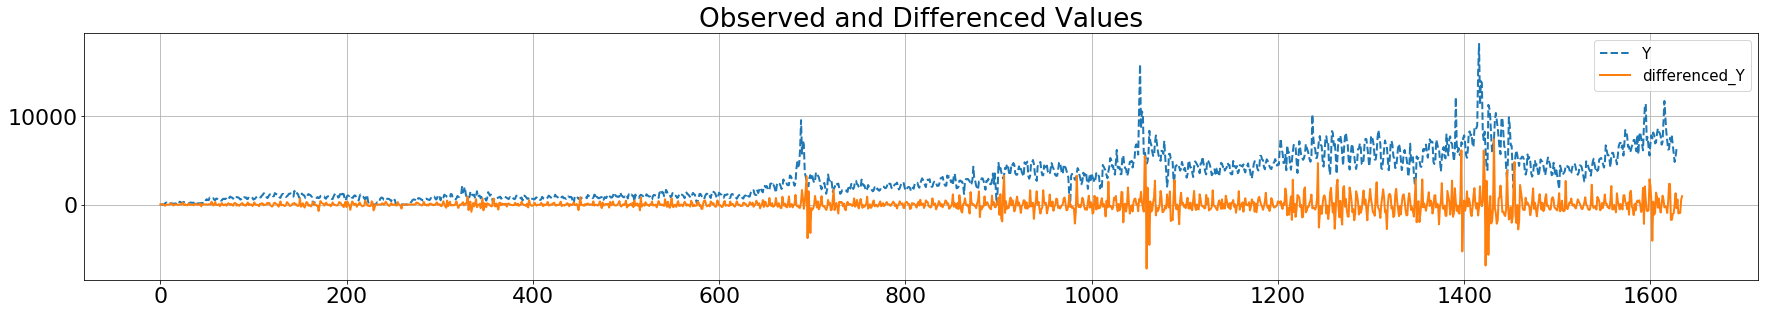

In [28]:
plt.subplot(2, 1, 1)
plt.plot(Y[7:], label='Y', linestyle='--', lw=2)
plt.plot(differenced_Y, label='differenced_Y', lw=2)
plt.title('Observed and Differenced Values')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show() 

### Plot ACF PACF

In [ ]:
#as result - no autocorrelation
for f in diff_df.columns:
    series = diff_df[f]
    print('----------------------------------------------------------------------------------------------------')
    plot_acf(series, lags=100)
    plot_pacf(series, lags=100)
    plt.title(f)
    plt.show()

### Add data features

In [ ]:
from datetime import datetime
 
#year = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year
df['year'] = df.index.month
df.head()

In [41]:
data_df = df.copy()
data_df['month'] = data_df.index.month
data_df['year'] = data_df.index.year
data_df['quater'] = data_df.index.quarter
data_df['week_day'] = data_df.index.dayofweek
data_df['week_of_year'] = data_df.index.weekofyear
data_df['day_of_year'] = data_df.index.dayofyear
data_df